In [36]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterSampler


In [37]:
# Define the stock symbol and timeframe
stock_symbol = "AAPL"
timeframe = "1mo"
prediction_days = 2  # Number of days to predict into the future

# Fetch the latest stock data using yfinance API
stock_data = yf.download(stock_symbol, period=timeframe, progress=False)

# Preprocess the data
stock_data = stock_data.dropna()  # Remove missing values


In [38]:
# Add features: previous day's closing price, SMA, EMA, RSI, MACD, Bollinger Bands
stock_data['PrevClose'] = stock_data['Close'].shift(1)
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['EMA_10'] = stock_data['Close'].ewm(span=10, adjust=False).mean()

delta = stock_data['Close'].diff()
gain = delta.mask(delta < 0, 0)
loss = -delta.mask(delta > 0, 0)
average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))
stock_data['RSI'] = rsi

ema_12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
macd = ema_12 - ema_26
signal_line = macd.ewm(span=9, adjust=False).mean()
stock_data['MACD'] = macd
stock_data['Signal Line'] = signal_line

rolling_mean = stock_data['Close'].rolling(window=20).mean()
rolling_std = stock_data['Close'].rolling(window=20).std()
upper_band = rolling_mean + (2 * rolling_std)
lower_band = rolling_mean - (2 * rolling_std)
stock_data['Upper Band'] = upper_band
stock_data['Lower Band'] = lower_band


In [39]:
# Split the data into features (X) and target variable (y)
X = stock_data[['PrevClose', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'Upper Band', 'Lower Band']].iloc[1:].values
y = stock_data['Close'].iloc[1:].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:

# Define the parameter distributions
param_distributions = {
    'n_estimators': list(range(50, 1001, 50)),
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': list(range(3, 11)),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Set the number of samples to generate
n_samples = 50

# Generate random parameter samples
param_samples = list(ParameterSampler(param_distributions, n_iter=n_samples, random_state=42))

# Initialize the best parameters list
best_params_array = []

# Perform grid search
best_score = None
best_params = None

for params in param_samples:
    model.set_params(**params)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)

    if best_score is None or score > best_score:
        best_score = score
        best_params = params

# Append the best parameters to the list
best_params_array.append(best_params)

# Print the best parameters
print("Best Parameters:", best_params)

# Create an instance of the XGBoost model
model = XGBRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

# Evaluate the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Best Hyperparameters:", best_params)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Best Parameters: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Train RMSE: 0.21088599495393293
Test RMSE: 2.135744723148764


In [49]:

# Retrieve the best hyperparameters from the best_params_array
best_params = best_params_array[0]  # Assuming there is only one set of best parameters

# Train the XGBoost model with the best hyperparameters
model = XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)

model.fit(X_train, y_train)


# Evaluate the model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 2.328608631401905
Test RMSE: 2.781928769341642


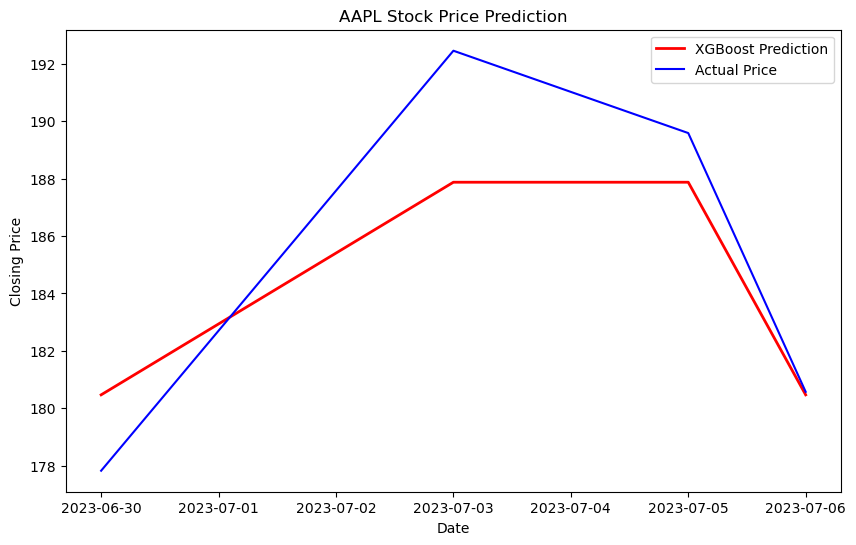

Predicted closing prices for the next 2 days:
Day 1 : 187.87622
Day 2 : 187.01015


In [50]:
# Predict future prices
last_data_point = stock_data[['PrevClose', 'SMA_10', 'EMA_10', 'RSI', 'MACD', 'Upper Band', 'Lower Band']].iloc[-1:].values
predictions = []
for _ in range(prediction_days):
    prediction = model.predict(last_data_point)[0]
    predictions.append(prediction)
    last_data_point = np.array([[
        prediction,
        stock_data['SMA_10'].iloc[-prediction_days:][0],
        stock_data['EMA_10'].iloc[-prediction_days:][0],
        stock_data['RSI'].iloc[-prediction_days:][0],
        stock_data['MACD'].iloc[-prediction_days:][0],
        stock_data['Upper Band'].iloc[-prediction_days:][0],
        stock_data['Lower Band'].iloc[-prediction_days:][0]
    ]])

# Plot the stock price data and XGBoost predictions
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index[-len(y_test_pred):], y_test_pred, color='red', linewidth=2, label='XGBoost Prediction')
plt.plot(stock_data.index[-len(y_test):], y_test, color='blue', label='Actual Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.legend()
plt.show()

# Print the predicted closing prices for the next `prediction_days`
print("Predicted closing prices for the next", prediction_days, "days:")
for i, prediction in enumerate(predictions):
    print("Day", i+1, ":", prediction)